# Projeto Final - Modelos Preditivos - Dataset do Censo

## Grupo:
- Lucas Natan Correia Couri - lncc2@cin.ufpe.br
- Mariama Celi Serafim de Oliveira - mcso@cin.ufpe.br
- Laianna Lana Virginio da Silva - llvs2@cin.ufpe.br
- Priscilla Amarante de Lima - pal4@cin.ufpe.br
- Liviany Reis Rodrigues - lrr@cin.ufpe.br

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import kruskal

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from numpy.random import randn
from numpy.random import seed

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Determinação da SEED utilizada no projeto
SEED = 6138

# 1. Entendimento do Negócio

O objetivo do problema é determinar se uma pessoa ganha mais ou menos de 50 mil dólares. Serão utilizadas as informações do censo americano (14 features) a fim de gerar os modelos.

# 2. Compreensão dos Dados

*   Descrição da base: https://archive.ics.uci.edu/ml/datasets/census+income

Número de Instâncias:
* Dados de Treino: 32561
* Dados de Teste: 16281

Valores Ausentes:
* Foram substituídos por " ?"

Número de Atributos: 14
* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Distribuição da Classe:
* '>50K' , '<=50K'.
    *   '>50K'  : 23.93% / 24.78% (without ' ?')
    *   '<=50K' : 76.07% / 75.22% (without ' ?')


# 3. Preparação dos Dados

## Carregando a Base de Dados

In [3]:
columns_name = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
df = pd.read_csv("Dados/adult.data", names = columns_name, index_col = False)
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


## Análise Exploratória de Dados

Nesta seção, serão analisados a distribuição e característica dos atributos, valores faltantes, possíveis outliers e nível de separatibilidade. 

### Tipos dos dados

In [4]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

Mudando os atributos para seus tipos corretos.

In [5]:
df['workclass'] = df['workclass'].astype('category')
df['education'] = df['education'].astype('category')
df['marital-status'] = df['marital-status'].astype('category')
df['occupation'] = df['occupation'].astype('category')
df['relationship'] = df['relationship'].astype('category')
df['race'] = df['race'].astype('category')
df['sex'] = df['sex'].astype('category')
df['native-country'] = df['native-country'].astype('category')
df['class'] = df['class'].astype('category')
df.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
class             category
dtype: object

### Descrição dos dados

Sumário dos dados contínuos.

In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Dados Duplicados

Checando dados duplicados. Ao final, verificamos que não há linhas duplicadas.

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df[df.duplicated()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class


### Preenchendo Dados Faltantes

In [9]:
def tratamento_faltantes(df, columns_name):
    ## Printa os atributos com dados faltantes (" ?")
    for coluna in columns_name:
        if len(df[df[coluna] == " ?"]) > 0:
            print(coluna)
            print(len(df[df[coluna] == " ?"]))
    
    ## Tratamento dos dados faltantes:
    atr_faltantes = ["workclass", "occupation", "native-country"]
    for atr in atr_faltantes:
        categorias_atr = df.groupby(atr).sum().index.tolist()
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(categorias_atr)
        df[atr] = df[atr].replace(" ?", np.nan)
        df[atr] = df[atr].interpolate(method = 'pad')

Tratamento dos dados faltantes: 
1. Transforma para numérico (LabelEnconder) 
2. Substitui " ?" por NaN (replace)
3. Utiliza a frequência dos vizinhos mais próximos para estimar um valor para NaN (interpolate)

In [10]:
tratamento_faltantes(df, columns_name)

workclass
1836
occupation
1843
native-country
582


### Checando outliers

<AxesSubplot:>

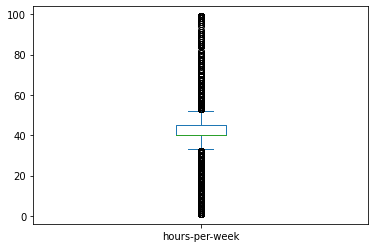

In [11]:
df['hours-per-week'].plot.box()

<AxesSubplot:>

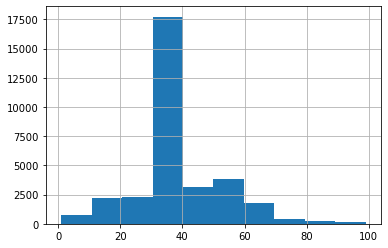

In [12]:
df['hours-per-week'].hist()

<AxesSubplot:>

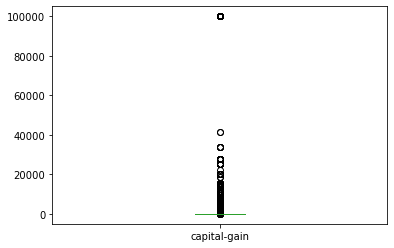

In [13]:
df['capital-gain'].plot.box()

<AxesSubplot:>

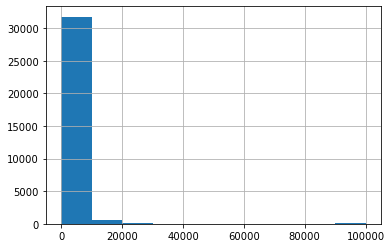

In [14]:
df['capital-gain'].hist()

<AxesSubplot:>

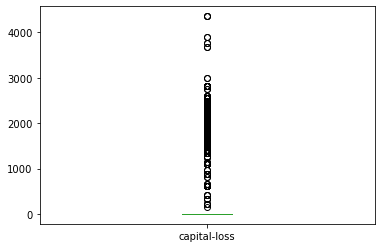

In [15]:
df['capital-loss'].plot.box()

<AxesSubplot:>

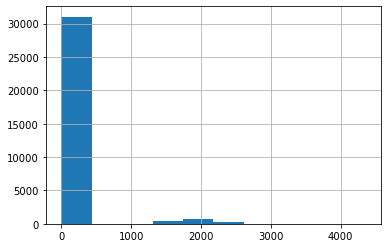

In [16]:
df['capital-loss'].hist()

### Colunas Redundantes

In [17]:
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


"education" e "education-num" significam a mesma coisa. Vamos utilizar "education-num" e dropar "education", já que "education-num" é a codificação ordinal de "education"

In [18]:
df['education'].value_counts()

 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

In [19]:
df['education-num'].value_counts()

9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: education-num, dtype: int64

### TO DO: Plotar região

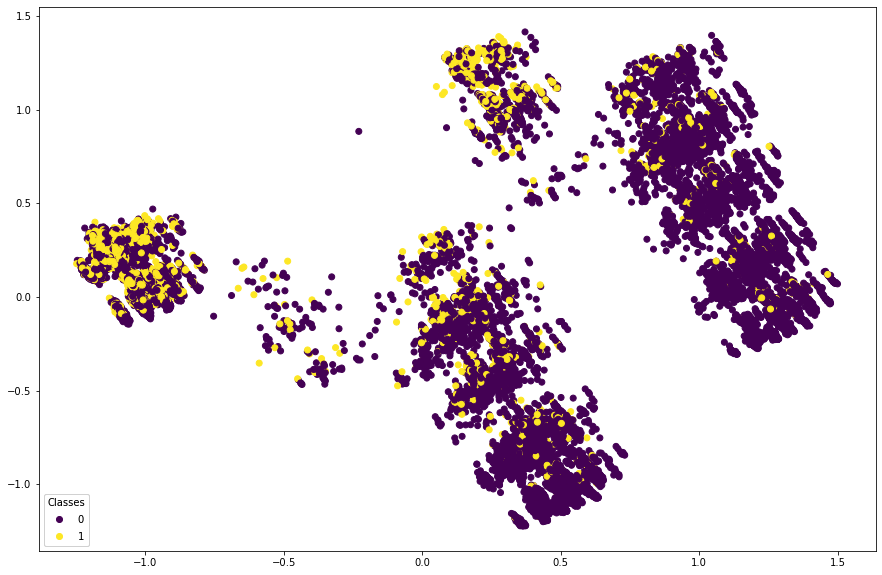

In [74]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(2)
X_pca = pca.fit_transform(preprocessing.minmax_scale(X_train))

fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()


### Frequência das Variáveis Categóricas (Value_Counts)

In [20]:
df['workclass'].value_counts()

 Private             24072
 Self-emp-not-inc     2686
 Local-gov            2204
 State-gov            1374
 Self-emp-inc         1177
 Federal-gov          1002
 Without-pay            15
 Never-worked            7
Name: workclass, dtype: int64

In [21]:
df['education'].value_counts()

 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

In [22]:
df['marital-status'].value_counts()

 Married-civ-spouse       14970
 Never-married            10667
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

In [23]:
df['occupation'].value_counts()

 Prof-specialty       4383
 Craft-repair         4358
 Exec-managerial      4315
 Adm-clerical         3980
 Sales                3863
 Other-service        3467
 Machine-op-inspct    2132
 Transport-moving     1703
 Handlers-cleaners    1470
 Farming-fishing      1036
 Tech-support          980
 Protective-serv       683
 Priv-house-serv       157
 Armed-Forces           10
Name: occupation, dtype: int64

In [24]:
df['relationship'].value_counts()

 Husband           13187
 Not-in-family      8292
 Own-child          5064
 Unmarried          3445
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

In [25]:
df['race'].value_counts()

 White                 27795
 Black                  3122
 Asian-Pac-Islander     1038
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [26]:
df['sex'].value_counts()

 Male      21775
 Female    10762
Name: sex, dtype: int64

In [27]:
df['native-country'].value_counts()

 United-States                 29676
 Mexico                          653
 Philippines                     200
 Germany                         141
 Canada                          124
 Puerto-Rico                     118
 El-Salvador                     109
 India                           101
 Cuba                             97
 England                          93
 Jamaica                          83
 South                            80
 China                            77
 Dominican-Republic               74
 Italy                            73
 Vietnam                          72
 Guatemala                        64
 Japan                            63
 Columbia                         61
 Poland                           60
 Taiwan                           51
 Haiti                            45
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 Greece                           30
 

In [28]:
df['class'].value_counts()

 <=50K    24698
 >50K      7839
Name: class, dtype: int64

No dataset de treino há apenas uma observação como " Holand-Netherlands", diante do tamanho do dataset (mais de 30mil linhas) optou-se por remover essa única linha com native-country=" Holand-Netherlands" de forma a evitar problemas de ausência do valor no dataset de teste.

In [29]:
df[df['native-country'] != " Holand-Netherlands"]['native-country'].value_counts()

 United-States                 29676
 Mexico                          653
 Philippines                     200
 Germany                         141
 Canada                          124
 Puerto-Rico                     118
 El-Salvador                     109
 India                           101
 Cuba                             97
 England                          93
 Jamaica                          83
 South                            80
 China                            77
 Dominican-Republic               74
 Italy                            73
 Vietnam                          72
 Guatemala                        64
 Japan                            63
 Columbia                         61
 Poland                           60
 Taiwan                           51
 Haiti                            45
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 Greece                           30
 

In [30]:
#df = df[df['native-country'] != " Holand-Netherlands"]

## Carregando e Processando o Conjunto de Teste

In [31]:
df_test = pd.read_csv("Dados/adult.test", names = columns_name, index_col = False, skiprows = 1)
df_test.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.


### Preenchendo Dados Faltantes

Realizando o mesmo procedimento de input utilizado no conjunto de treinamento.

In [32]:
tratamento_faltantes(df_test, columns_name)

workclass
963
occupation
966
native-country
274


## Codificação das Variáveis Categóricas

Realizaremos a codificação One Hot Encoding, dado que os modelos a serem utilizados necessitam de entradas numérica. Esse tipo de codifição é indicado para variáveis categóricas nominais, pois atribui distâncias uniformes às categorias.

In [33]:
def onehot_encoder(df):

    colunas_cat = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
    
    for coluna in colunas_cat:

        #print(coluna)
        df_coluna = pd.get_dummies(df[coluna], prefix=coluna)
        df = df.join(df_coluna)
    
    return df

In [34]:
df = onehot_encoder(df)
df.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0,0,0,0,0,0,0,1,0,0


In [35]:
df_test = onehot_encoder(df_test)
df_test.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,0,0,0,0,0,0,0,1,0,0


Verificamos que no conjunto de teste não havia observações com o valor 'Holand-Netherlands' em 'native-country', fato que causava inconsistência com o conjunto de treinamento ao realizar o Hot Enconding. A fim de resolver esse problema, adicionamos manualmente a coluna 'native-country_ Holand-Netherlands'.

In [36]:
coluna = 'native-country_ Holand-Netherlands'
#df[coluna]
df_test[coluna] = 0

## Normalizando Variáveis Contínuas

Indica-se normalização uma vez que alguns modelos que serão utilizados são baseados em distância. Caso haja escala de distância muito distinta, pode ocorrer enviesamento em algumas features e consequentemente comprometimento na performance do classificador.

In [37]:
normalize = MinMaxScaler()

In [38]:
colunas = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]

df[colunas] = normalize.fit_transform(df[colunas])
df_test[colunas] = normalize.fit_transform(df_test[colunas])

In [39]:
df[colunas].describe()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,education-num
count,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,0.295692,0.120547,0.010785,0.020057,0.402452,0.605454
std,0.186822,0.071689,0.073880,0.092539,0.125989,0.171442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.071679,0.000000,0.000000,0.397959,0.533333
50%,0.273973,0.112788,0.000000,0.000000,0.397959,0.600000
75%,0.424658,0.152611,0.000000,0.000000,0.448980,0.733333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dividindo o Conjuntos de Dados

In [40]:
colunas_drop = ["class", "education", "workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

X_train = df.drop(colunas_drop, axis = 1).to_numpy()
y_train = df["class"].values
X_test = df_test.drop(colunas_drop, axis = 1).to_numpy()
y_test = df_test["class"].values

Codificando as classes para valores numéricos:
- '<=50K' :  0
- '>50K'  : 1 

In [41]:
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# 4. Modelagem

Definindo tamanho do folder no cross validation.

In [42]:
cv = model_selection.StratifiedKFold(n_splits=10)

## KNN

Para avaliação do KNN foram considerados o número de vizinhos (n_neighbors) e o tipo de distância (metric).

In [43]:
def val_knn(X_train, y_train, parameters, cv, SEED):
    
    knn = KNeighborsClassifier()
    
    search = RandomizedSearchCV(knn,
                                parameters,
                                n_iter = 50,
                                scoring = 'accuracy',
                                n_jobs = -1,
                                cv = cv,
                                random_state = SEED)
    
    result_knn = search.fit(X_train, y_train)
    
    print('=========Resultados do Random Search para o KNN==========')
    print(f'Melhor Score: {result_knn.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_knn.best_params_}')
    
    return result_knn

In [44]:
#Definindo parâmetros para avaliação
parameters = dict()
parameters['n_neighbors'] = range(1, 100)
parameters['metric'] = ['euclidean','manhattan']

# result_knn = val_knn(X_train, y_train, parameters, cv, SEED)

**Melhores parâmetros para KNN:**
- n_neighbors: 23
- metric': 'manhattan'

## Árvore de Decisão Simples

Para avaliação da árvore de decisão foram considerados a profundidade da árvore (max_depth), o critério de divisão (criteon), número mínimo de amostra para realizar divisão (min_samples_split), mínimo de amostras necessárias para ser uma folha (min_samples_leaf).

In [45]:
def val_tree(X_train, y_train, parameters, cv, SEED):
    
    decisionTree = DecisionTreeClassifier()
    
    search = RandomizedSearchCV(decisionTree,
                                parameters,
                                n_iter = 50,
                                scoring = 'accuracy',
                                n_jobs = -1,
                                cv = cv,
                                random_state = SEED)
    
    result_tree = search.fit(X_train, y_train)
    
    print('=========Resultados do Random Search para a Árvore de Decisão Simples==========')
    print(f'Melhor Score: {result_tree.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_tree.best_params_}')
    
    return result_tree

In [46]:
#Definindo parâmetros para avaliação
parameters = dict()
parameters['criterion'] = ['gini', 'entropy']
parameters['max_depth'] = range(1,30)
parameters['min_samples_split'] = range(1,20)
parameters['min_samples_leaf'] = range(1,10)

# result_tree = val_tree(X_train, y_train, parameters, cv, SEED)

**Melhores parâmetros para Árvore de Decisão:**

- criterion: 'entropy'
- max_depth: 10
- min_samples_split: 5
- min_samples_leaf: 6

## Random Forest

Para avaliação do Random Forest foram considerados o número de árvores da floresta (n_estimators), o critério de divisão (criteon), número mínimo de amostra para realizar divisão (min_samples_split), mínimo de amostras necessárias para ser uma folha (min_samples_leaf) e número máximo de features (max_features) .

In [47]:
def val_rf(X_train, y_train, parameters, cv, SEED):

    rf = RandomForestClassifier(random_state = SEED)

    search = GridSearchCV(rf,
                          parameters,
                          scoring = "accuracy",
                          n_jobs = -1,
                          cv = cv)

    result_rf = search.fit(X_train, y_train)
    
    print('=========Resultados do Grid Search para Random Forest==========')
    print(f'Melhor Score: {result_rf.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_rf.best_params_}')

    return result_rf


## Tentativa 1 (18min)

In [48]:
parameters = dict()
parameters['n_estimators'] = range(10, 301, 20)
parameters['criterion'] = ["gini", "entropy"]
parameters['max_features'] = ["auto", "sqrt", "log2"]

#result_rf_1 = val_rf(X_train, y_train, parameters, cv, SEED)

## Tentativa 2 (47min)

In [49]:
parameters = dict()
parameters['n_estimators'] = range(300, 451, 10)
parameters['criterion'] = ["gini", "entropy"]
parameters['max_features'] = ["auto", "sqrt", "log2"]

#result_rf_1 = search_rf(parameters, cv, X_train, y_train, SEED)

## Tentativa 3 (17min)

In [50]:
parameters = dict()
parameters['n_estimators'] = range(408, 413, 1)
parameters['criterion'] = ["gini", "entropy"]
parameters['max_features'] = ["auto", "sqrt", "log2"]

#result_rf_3 = search_rf(parameters, cv, X_train, y_train, SEED)

## Tentativa 4

In [51]:
parameters = dict()
parameters['n_estimators'] = [190, 440, 412]
parameters['criterion'] = ["gini", "entropy"]
parameters['max_features'] = ["auto", "sqrt", "log2"]
parameters['min_samples_leaf'] = [1, 4]
parameters['min_samples_split'] = [2, 10]
#parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

#result_rf_4 = search_rf(parameters, cv, X_train, y_train, SEED)

**Melhores parâmetros para Random Forest:**

- n_estimators: 440
- criterion: "gini"
- max_features: "auto"
- min_samples_split: 4
- min_samples_leaf: 10

## Rede Neural MLP

Para avaliação da Rede Neural MLP foram considerados números de camadas escondidas (hidden_layer_sizes), a função de ativação (activation), algorítmos de treinamento (solver), tipo de taxa de aprendizado (learning_rate). 

In [52]:
def val_mlp(X_train, y_train, parameters, cv, SEED, search_type = 0):

    mlp = MLPClassifier(random_state = SEED)
    
    if search_type == 0:
        search = GridSearchCV(mlp,
                            parameters,
                            scoring = "accuracy",
                            n_jobs = -1,
                            cv = cv)
    else:
        search = RandomizedSearchCV(mlp,
                                    parameters,
                                    n_iter = 100,
                                    scoring = "accuracy",
                                    n_jobs = -1,                            
                                    cv = cv,
                                    random_state = SEED)

    result_mlp = search.fit(X_train, y_train)
    
    print(f'=========Resultados do {"Grid" if (search_type == 0) else "Random"} Search para MLP==========')
    print(f'Melhor Score: {result_mlp.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_mlp.best_params_}')

    return result_mlp

### Tentativa 1 (55 min)

In [53]:
# define search space for MPL
parameters = dict()
parameters["hidden_layer_sizes"] = [(4,4), (20,15),(50,50), (100,50), (50,100), (100, 250),(4,10,4),(20,10,5),(250, 100, 50)]
parameters["activation"] = ["logistic", "tanh", "relu", "identity"]
parameters["solver"] = ["lbfgs", "sgd", "adam"]

# result_mlp_1 = val_mlp(X_train, y_train, parameters, cv, SEED, 1)

### Tentativa 2

In [54]:
#Adicionando leaning_rate e retirando algumas opções
parameters = dict()
parameters["hidden_layer_sizes"] = [(4,4), (20,15),(50,50), (100,50), (50,100), (100, 250),(4,10,4),(20,10,5),(250, 100, 50)]
parameters["activation"] = ["logistic", "tanh", "relu"]
parameters["solver"] = ["lbfgs", "adam"]
parameters["learning_rate"] = ["constant", "invscaling", "adaptive"] 

# result_mlp_2 = val_mlp(X_train, y_train, parameters, cv, SEED)


### Tentativa 3

In [55]:
#Variando camadas e retirando alguns valores
parameters = dict()
parameters["hidden_layer_sizes"] = [(50,30,20,10), (20,15), (20,20,20,20), (100, 250), (100, 250, 300,450), (250, 100, 50)]
parameters["activation"] = ["tanh"]
parameters["solver"] = ["lbfgs"]
parameters["learning_rate"] = ["constant", "invscaling", "adaptive"] 

# result_mlp_3 = val_mlp(X_train, y_train, parameters, cv, SEED)

### Tentativa 4

In [56]:
#Variando camadas e retirando alguns valores
space = dict()
parameters["hidden_layer_sizes"] = [(5,5,5,5), (10,10,10,10), (50,50,50,50), (10,10,10,10,10)]
parameters["activation"] = ["logistic", "tanh"]
parameters["solver"] = ["lbfgs"]
parameters["learning_rate"] = ["constant", "invscaling", "adaptive"] 

# result_mlp_4 = val_mlp(X_train, y_train, parameters, cv, SEED)

**Melhores parâmetros para Rede Neural MLP:**

- hidden_layer_sizes: 
- activation: 
- solver: 
- learning_rate: 

## Comitê de Redes Neurais

Para avaliação do Comitê de Redes Neurais foram considerados números de camadas escondidas (hidden_layer_sizes), número de interações (max_iter), quantidade de classificadores no bagging (n_estimators), tamanho da amostra escolhida para treinar os classificadores (max_samples). 

In [57]:
def val_bgc(X_train, y_train, parameters, cv, SEED, hidden_l, max_iterations):
       
    mlp = MLPClassifier(hidden_layer_sizes = hidden_l,
                        max_iter = max_iterations,
                        random_state = SEED
                        )
    
    search = GridSearchCV(BaggingClassifier(mlp),
                          parameters,
                          scoring = "accuracy",
                          #cv = cv,
                          n_jobs= -1
                          )

    result_bgc = search.fit(X_train, y_train)
   
    print(f'=========Resultados do Grid Search para Bagging Classifier com Redes Neurais MLP==========')
    print(f'Melhor Score: {result_bgc.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_bgc.best_params_}')

    return result_bgc

In [58]:
parameters = dict()
parameters["n_estimators"] = [10, 20]
parameters["max_samples"] = [30, 50]

hidden_l = (10, 10)
max_iterations = 20

#result_bgc = val_bgc(X_train, y_train, parameters, cv, SEED, hidden_l, max_iterations)

**Melhores parâmetros para Comitê de Redes Neurais:**

- hidden_layer_sizes: (10, 10)
- max_iter: 200
- n_estimators: 
- max_samples: 

## Comitê Heterogêneo

Este comitê utiliza quatro estimadores fracos (KNN, árvore de decisão, random forest e rede neural MLP).

In [59]:
def val_ensemble(X_train, y_train, estimators, cv):
       
    ensemble = VotingClassifier(estimators)
    
    result_ens = model_selection.cross_val_score(ensemble, X_train, y_train, cv = cv)
   
    print(f'=========Resultados do Comitê Heterogêneo com KNN, Árvore de Decisão, Random Forest e MLP==========')
    print(f'Score: {result_ens.mean()}')

    return result_ens

In [60]:
estimators = []

model1 = KNeighborsClassifier()
estimators.append(('KNN', model1))

model2 = DecisionTreeClassifier()
estimators.append(('Tree', model2))

model3 = RandomForestClassifier()
estimators.append(('RF', model3))

model4 = MLPClassifier()
estimators.append(('MLP', model4))

#result_ens = val_ensemble(X_train, y_train, estimators, cv)

## Melhores Modelos Encontrados

Definição dos modelos de classificação com as melhores configurações encontradas na seção anterior.

In [61]:
# criação dos modelos com os melhores parâmetros
knn = KNeighborsClassifier(n_neighbors = 23, metric = 'manhattan')

arvore = DecisionTreeClassifier(min_samples_split = 4, min_samples_leaf = 4, max_depth = 10, criterion = 'gini')

rf = RandomForestClassifier(n_estimators = 440,
                            criterion = "gini",
                            max_features = "auto",
                            min_samples_leaf = 4,
                            min_samples_split = 10,
                            random_state = SEED)

mlp = MLPClassifier(activation = 'tanh',
                    hidden_layer_sizes = (5, 5, 5, 5),
                    learning_rate = 'constant',
                    solver = 'lbfgs')

comite_mlp = BaggingClassifier(MLPClassifier(hidden_layer_sizes = (10, 10),
                                                              max_iter = 10,
                                                              random_state = SEED),
                               n_estimators = 10,
                               max_samples = 10
                              )

comite_h = VotingClassifier(estimators)

Adicionamos os modelos em uma lista a fim de coletar suas avaliações.

In [62]:
models = []
models.append(('knn', knn))
models.append(('arvore', arvore))
models.append(('random', rf))
models.append(('mlp', mlp))
models.append(('comite_mlp', comite_mlp))
models.append(('comite_h', comite_h))

### Execução do Modelo Experimental

In [63]:
#Avaliação de cada modelo nas amotragens estratificas
print('\nDesempenhos médios dos modelos:')

results = []
names = []
for name, model in models:
    
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy')
    
    results.append(cv_results)
    names.append(name)
    
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")


Desempenhos médios dos modelos:
knn: 0.838215124009212 (0.004523633948069289)
arvore: 0.8573934022606148 (0.004472109518890755)
random: 0.864646713515452 (0.005550392977267561)
mlp: 0.8543506244814726 (0.0038616612992408692)
comite_mlp: 0.6559242369248868 (0.20345240776663798)
comite_h: 0.8569016336109584 (0.004485933915265607)


### Comparação de Modelos

A partir dos valores encontrados na validação cruzada acima, iremos realizar o teste de significânica estatística a fim de comparar os classificadores.

Utilizamos o teste **Kruskal-Wallis**

Passos: 
1. Detectamos se havia distribuições distintas.
2. Caso encontrado uma distribuição distinta, realizamos o teste Kruskal par a par para determinar qual classificador é estatísticamente diferente do outro.

#### Teste de hipótese analisando o p-value

In [64]:
stat, p = stats.kruskal(results[0], results[1], results[2], results[3], results[4], results[5])
print(f"p_value: {p}. Comparison stats: {stat}")

p_value: 4.579293285749974e-09. Comparison stats: 47.45929560237946


In [65]:
alpha = 0.05
if p > alpha:
    print('\nMesma distribuição (aceita H0)')
else:
    print('\nDiferentes distribuições (rejeita H0)')

alg = ["KNN        ", "ÁRVORE     ", "RF         ", "MLP        ", "COMITÊ MLP ", "COMITÊ HET."]
print("\nCOMPARAÇÃO:")
for i in range(len(results)):
    for j in range(i+1, len(results)):
        print(f'   {alg[i]} | {alg[j]} -> statistic = {round(stats.kruskal(results[i],results[j]).statistic, 3)},\tp_value = {round(stats.kruskal(results[i],results[j]).pvalue, 4)},\t{"Mesma distribuição (aceita H0)" if (stats.kruskal(results[i],results[j]).pvalue > alpha) else "Diferentes distribuições (rejeita H0)"} ')


Diferentes distribuições (rejeita H0)

COMPARAÇÃO:
   KNN         | ÁRVORE      -> statistic = 14.34,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   KNN         | RF          -> statistic = 14.296,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   KNN         | MLP         -> statistic = 14.296,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   KNN         | COMITÊ MLP  -> statistic = 14.34,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   KNN         | COMITÊ HET. -> statistic = 14.307,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   ÁRVORE      | RF          -> statistic = 6.626,	p_value = 0.0101,	Diferentes distribuições (rejeita H0) 
   ÁRVORE      | MLP         -> statistic = 3.301,	p_value = 0.0692,	Mesma distribuição (aceita H0) 
   ÁRVORE      | COMITÊ MLP  -> statistic = 14.372,	p_value = 0.0002,	Diferentes distribuições (rejeita H0) 
   ÁRVORE      | COMITÊ HET. -> statistic = 0.036,	p_value = 0.8498,	Mesma distribuição

## Avaliando o Modelo na Base de Teste

Treinamento dos modelos no conjunto de treino completo (sem divisão de validação).

In [66]:
knn.fit(X_train, y_train)
arvore.fit(X_train, y_train)
rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)
comite_mlp.fit(X_train, y_train)
comite_h.fit(X_train, y_train)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('Tree', DecisionTreeClassifier()),
                             ('RF', RandomForestClassifier()),
                             ('MLP', MLPClassifier())])

Predição de cada modelo para a base de teste.

In [67]:
y_test_prediction_knn = knn.predict(X_test)
y_test_prediction_arvore = arvore.predict(X_test)
y_test_prediction_rf = rf.predict(X_test)
y_test_prediction_mlp = mlp.predict(X_test)
y_test_prediction_comite_mlp = comite_mlp.predict(X_test)
y_test_prediction_comite_h = comite_h.predict(X_test)

# 4. Avaliação

## Apresentação de Resultados


Acurácia KNN: Treinamento 0.8483265205765743  Teste 0.8345310484613967
Clasification Report:               precision    recall  f1-score   support

           0       0.87      0.92      0.89     12435
           1       0.68      0.56      0.61      3846

    accuracy                           0.83     16281
   macro avg       0.78      0.74      0.75     16281
weighted avg       0.83      0.83      0.83     16281

Confussion Matrix:
 [[11442   993]
 [ 1701  2145]]

Acurácia ÁRVORE: Treinamento 0.8676583581768448  Teste 0.8433757140224802
Clasification Report:               precision    recall  f1-score   support

           0       0.87      0.94      0.90     12435
           1       0.73      0.54      0.62      3846

    accuracy                           0.84     16281
   macro avg       0.80      0.74      0.76     16281
weighted avg       0.83      0.84      0.83     16281

Confussion Matrix:
 [[11665   770]
 [ 1780  2066]]

Acurácia RF: Treinamento 0.8802593969941912  Teste 0

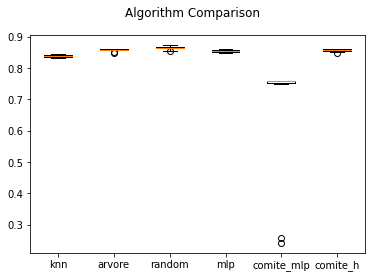

In [68]:
print("\nAcurácia KNN: Treinamento",  knn.score(X_train, y_train)," Teste" ,knn.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_knn))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_knn))

print("\nAcurácia ÁRVORE: Treinamento",  arvore.score(X_train, y_train)," Teste" , arvore.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_arvore))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_arvore))

print("\nAcurácia RF: Treinamento",  rf.score(X_train, y_train)," Teste" ,rf.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_rf))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_rf))

print("\nAcurácia MLP: Treinamento",  mlp.score(X_train, y_train)," Teste" ,mlp.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_mlp))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_mlp))

print("\nAcurácia COMITÊ MLP: Treinamento",  comite_mlp.score(X_train, y_train)," Teste" ,comite_mlp.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_comite_mlp))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_comite_mlp))

print("\nAcurácia COMITÊ HETEROGÊNEO: Treinamento",  comite_h.score(X_train, y_train)," Teste" ,comite_h.score(X_test, y_test))
print("Clasification Report:", classification_report(y_test, y_test_prediction_comite_h))
print("Confussion Matrix:\n", confusion_matrix(y_test, y_test_prediction_comite_h))

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Análise de Features

In [75]:
colunas_drop = ["class", "education", "workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

In [76]:
model1 = arvore.fit(X_train, y_train)

In [77]:
text_representation1 = tree.export_text(arvore)
print(text_representation1)

|--- feature_16 <= 0.50
|   |--- feature_3 <= 0.07
|   |   |--- feature_2 <= 0.77
|   |   |   |--- feature_4 <= 0.51
|   |   |   |   |--- feature_5 <= 0.40
|   |   |   |   |   |--- feature_0 <= 0.23
|   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |--- feature_1 <= 0.01
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.01
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_1 >  0.01
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_1 >  0.01
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.16
|   |   |   |   |   |   |   |   |   |--- feature_60 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_60 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_0 >  0.16
|   |   |   |   |   |   |   |   |   |--- feature_23 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--

In [79]:
#plotar a melhor árvore
feature_names = df.drop(colunas_drop, axis = 1).columns

In [82]:
for i in range(len(arvore.feature_importances_)):
  print(f"{feature_names[i]}: {arvore.feature_importances_[i]} ")

age: 0.049543715101489014 
fnlwgt: 0.012593469963470995 
education-num: 0.21369480264639765 
capital-gain: 0.19295222874835305 
capital-loss: 0.06676799165013952 
hours-per-week: 0.033315647564113864 
workclass_ Federal-gov: 0.0020056421927136282 
workclass_ Local-gov: 0.0 
workclass_ Never-worked: 0.0 
workclass_ Private: 0.0011693885276409346 
workclass_ Self-emp-inc: 0.0004133447991783518 
workclass_ Self-emp-not-inc: 0.0055258311420065785 
workclass_ State-gov: 0.0004931516780898413 
workclass_ Without-pay: 0.0 
marital-status_ Divorced: 0.0012000782449710181 
marital-status_ Married-AF-spouse: 0.00016055101391569836 
marital-status_ Married-civ-spouse: 0.38831386051271405 
marital-status_ Married-spouse-absent: 0.0 
marital-status_ Never-married: 0.0004578073179820085 
marital-status_ Separated: 5.875523308698529e-05 
marital-status_ Widowed: 0.0 
occupation_ Adm-clerical: 0.0002985637404494877 
occupation_ Armed-Forces: 0.0 
occupation_ Craft-repair: 0.0005287209143805641 
occupa

In [88]:
sorted(zip(feature_names, arvore.feature_importances_), reverse=True,  key=lambda x: x[1])

[('marital-status_ Married-civ-spouse', 0.38831386051271405),
 ('education-num', 0.21369480264639765),
 ('capital-gain', 0.19295222874835305),
 ('capital-loss', 0.06676799165013952),
 ('age', 0.049543715101489014),
 ('hours-per-week', 0.033315647564113864),
 ('fnlwgt', 0.012593469963470995),
 ('occupation_ Exec-managerial', 0.010472654136431045),
 ('occupation_ Prof-specialty', 0.0058295282835803125),
 ('workclass_ Self-emp-not-inc', 0.0055258311420065785),
 ('relationship_ Wife', 0.004741497484127593),
 ('sex_ Male', 0.003162442786945564),
 ('workclass_ Federal-gov', 0.0020056421927136282),
 ('occupation_ Sales', 0.0019270577462176042),
 ('occupation_ Tech-support', 0.0012583173982728783),
 ('marital-status_ Divorced', 0.0012000782449710181),
 ('workclass_ Private', 0.0011693885276409346),
 ('native-country_ United-States', 0.0009892750449159685),
 ('occupation_ Transport-moving', 0.0006010157781255862),
 ('occupation_ Craft-repair', 0.0005287209143805641),
 ('race_ White', 0.00050670

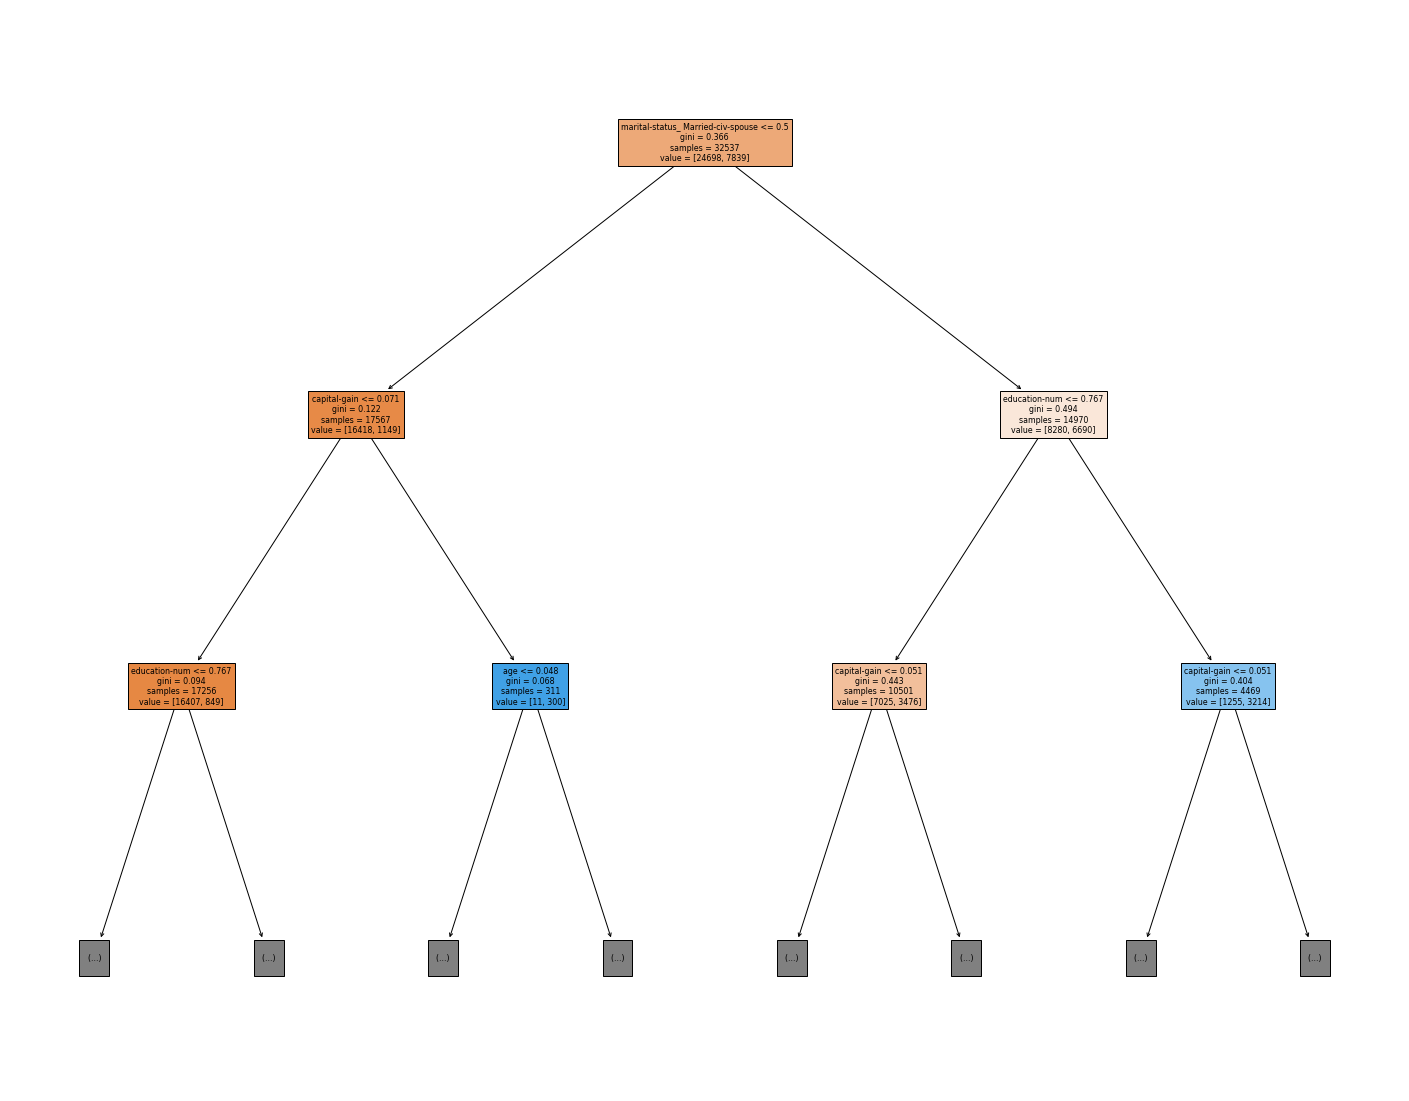

In [90]:
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(arvore, 
                   feature_names = feature_names,  
                  #  class_names=list(label_encoder.classes_),
                   filled=True,
                   max_depth = 5)

In [84]:
arvore2 = DecisionTreeClassifier(max_depth = 5, criterion = 'gini')
model2 = arvore2.fit(X_train, y_train)

In [85]:
text_representation2 = tree.export_text(arvore2)
print(text_representation2)

|--- feature_16 <= 0.50
|   |--- feature_3 <= 0.07
|   |   |--- feature_2 <= 0.77
|   |   |   |--- feature_4 <= 0.51
|   |   |   |   |--- feature_5 <= 0.40
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  0.40
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  0.51
|   |   |   |   |--- feature_1 <= 0.08
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  0.08
|   |   |   |   |   |--- class: 0
|   |   |--- feature_2 >  0.77
|   |   |   |--- feature_5 <= 0.43
|   |   |   |   |--- feature_0 <= 0.23
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.23
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_5 >  0.43
|   |   |   |   |--- feature_0 <= 0.14
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.14
|   |   |   |   |   |--- class: 0
|   |--- feature_3 >  0.07
|   |   |--- feature_0 <= 0.05
|   |   |   |--- class: 0
|   |   |--- feature_0 >  0.05
|   |   |   |--- feature_1 <= 0.01
|   |   |   |

In [86]:
for i in range(len(arvore2.feature_importances_)):
  print(f"{feature_names[i]}: {arvore2.feature_importances_[i]} ")

age: 0.011787766513063227 
fnlwgt: 0.0017227100569076484 
education-num: 0.23398006249273484 
capital-gain: 0.2179347454096459 
capital-loss: 0.046161693252986837 
hours-per-week: 0.022044547660491083 
workclass_ Federal-gov: 0.0 
workclass_ Local-gov: 0.0 
workclass_ Never-worked: 0.0 
workclass_ Private: 0.0 
workclass_ Self-emp-inc: 0.0 
workclass_ Self-emp-not-inc: 0.00029667070229717155 
workclass_ State-gov: 0.0 
workclass_ Without-pay: 0.0 
marital-status_ Divorced: 0.0 
marital-status_ Married-AF-spouse: 0.0 
marital-status_ Married-civ-spouse: 0.4652805638155576 
marital-status_ Married-spouse-absent: 0.0 
marital-status_ Never-married: 0.0 
marital-status_ Separated: 0.0 
marital-status_ Widowed: 0.0 
occupation_ Adm-clerical: 0.0 
occupation_ Armed-Forces: 0.0 
occupation_ Craft-repair: 0.0 
occupation_ Exec-managerial: 0.0 
occupation_ Farming-fishing: 7.736367967590942e-05 
occupation_ Handlers-cleaners: 0.00038395690547519794 
occupation_ Machine-op-inspct: 0.0 
occupatio

In [89]:
sorted(zip(feature_names, arvore2.feature_importances_), reverse=True,  key=lambda x: x[1])

[('marital-status_ Married-civ-spouse', 0.4652805638155576),
 ('education-num', 0.23398006249273484),
 ('capital-gain', 0.2179347454096459),
 ('capital-loss', 0.046161693252986837),
 ('hours-per-week', 0.022044547660491083),
 ('age', 0.011787766513063227),
 ('fnlwgt', 0.0017227100569076484),
 ('occupation_ Handlers-cleaners', 0.00038395690547519794),
 ('occupation_ Other-service', 0.00032991951116453114),
 ('workclass_ Self-emp-not-inc', 0.00029667070229717155),
 ('occupation_ Farming-fishing', 7.736367967590942e-05),
 ('workclass_ Federal-gov', 0.0),
 ('workclass_ Local-gov', 0.0),
 ('workclass_ Never-worked', 0.0),
 ('workclass_ Private', 0.0),
 ('workclass_ Self-emp-inc', 0.0),
 ('workclass_ State-gov', 0.0),
 ('workclass_ Without-pay', 0.0),
 ('marital-status_ Divorced', 0.0),
 ('marital-status_ Married-AF-spouse', 0.0),
 ('marital-status_ Married-spouse-absent', 0.0),
 ('marital-status_ Never-married', 0.0),
 ('marital-status_ Separated', 0.0),
 ('marital-status_ Widowed', 0.0),
 

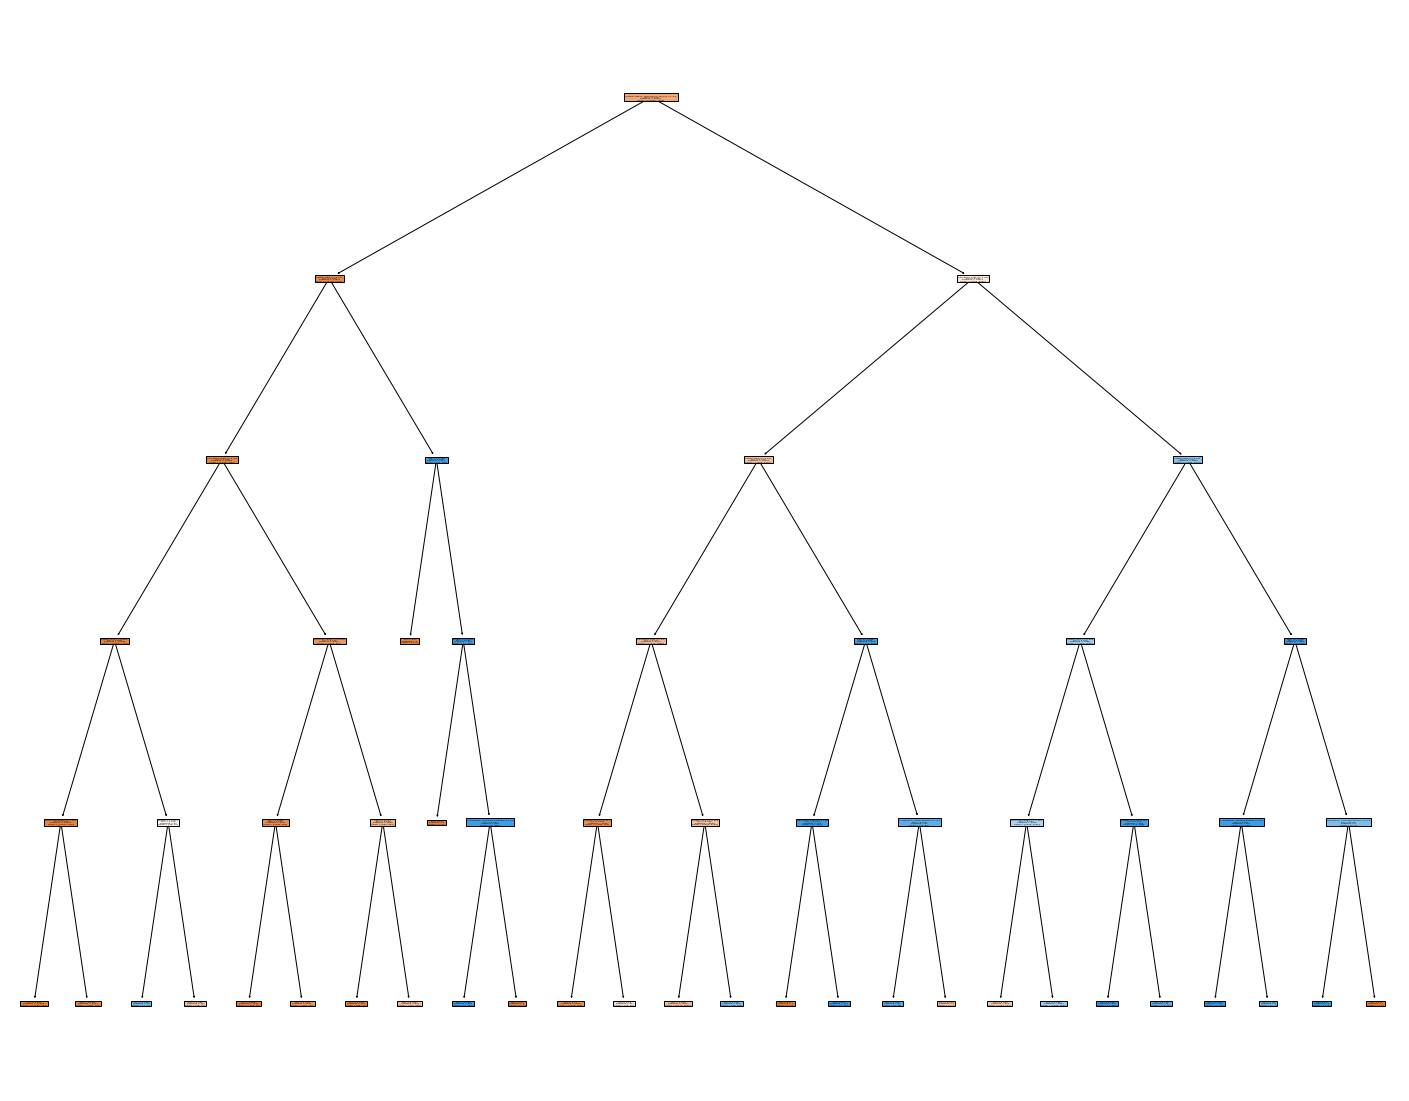

In [87]:
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(arvore2, 
                   feature_names = feature_names,  
                  #  class_names=list(label_encoder.classes_),
                   filled=True,
                   max_depth = 5)

# Significance Stats Tests

In [69]:
stat, p = kruskal(np.array([knn.score(X_test, y_test)]),
                  np.array([arvore.score(X_test, y_test)]),
                  np.array([rf.score(X_test, y_test)]),
                  np.array([mlp.score(X_test, y_test)]),
                  np.array([comite_mlp.score(X_test, y_test)]),
                  np.array([comite_h.score(X_test, y_test)])
                 )
print('Kruskal-Wallis Statistic: s = %.3f, p = %.3f' % (stat, p))

Kruskal-Wallis Statistic: s = 5.000, p = 0.416


In [70]:
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Same distributions (fail to reject H0)
